In [1]:
"""
This module contains the helper functions to assist with the running and analysis of the
PWP model.
"""

import numpy as np
import seawater as sw
import matplotlib.pyplot as plt
import PWP
from datetime import datetime
import warnings

#warnings.filterwarnings("error")
#warnings.simplefilter('error', RuntimeWarning)

#from IPython.core.debugger import set_trace
#debug_here = set_trace

def run_demo1():
    """
    Example script of how to run the PWP model. 
    This run uses summertime data from the Beaufort gyre
    """
    
    #ds = xr.Dataset({'t': (['z'], prof_dset['t'].values), 's': (['z'], prof_dset['s'].values), 'd': (['z'], prof_dset['d'].values), 'z': (['z'], prof_dset['z'].values), 'lat': 74.0})
    
    forcing_fname = 'beaufort_met.nc'
    prof_fname = 'beaufort_profile.nc'
    print("Running Test Case 1 with data from Beaufort gyre...")
    forcing, pwp_out = PWP.run(met_data=forcing_fname, prof_data=prof_fname, suffix='demo1_nodiff', save_plots=True, diagnostics=False)
    
    #debug_here()
def run_demo2(winds_ON=True, emp_ON=True, heat_ON=True, drag_ON=True):
    
    """
    Example script of how to run the PWP model.
    This run uses summertime data from the Atlantic sector of the Southern Ocean
    """
    
    forcing_fname = 'SO_met_30day.nc'
    prof_fname = 'SO_profile1.nc'
    print("Running Test Case 2 with data from Southern Ocean...")
    p={}
    p['rkz']=1e-6
    p['dz'] = 2.0 
    p['max_depth'] = 500.0 
    p['rg'] = 0.25 # to turn off gradient richardson number mixing set to 0. (code runs much faster)
    p['winds_ON'] = winds_ON
    p['emp_ON'] = emp_ON
    p['heat_ON'] = heat_ON
    p['drag_ON'] = drag_ON
    
    if emp_ON: 
        emp_flag=''
    else:
        emp_flag='_empOFF'
        
    if winds_ON: 
        winds_flag=''
    else:
        winds_flag='_windsOFF'
        
    if heat_ON: 
        heat_flag=''
    else:
        heat_flag='_heatingOFF'
        
    if drag_ON:
        drag_flag=''
    else:
        drag_flag='_dragOFF'
        
    suffix = 'demo2_1e6diff%s%s%s%s' %(winds_flag, emp_flag, heat_flag, drag_flag)
    forcing, pwp_out = PWP.run(met_data=forcing_fname, prof_data=prof_fname, suffix=suffix, save_plots=True, param_kwds=p)
     

def set_params(lat, dt=3., dz=1., max_depth=100., mld_thresh=1e-4, dt_save=1., rb=0.65, rg=0.25, rkz=0., beta1=0.6, beta2=20.0, heat_ON=True, winds_ON=True, emp_ON=True, drag_ON=True):
    
    """
    This function sets the main paramaters/constants used in the model.
    These values are packaged into a dictionary, which is returned as output.
    Definitions are listed below.
    
    CONTROLS (default values are in [ ]):
    lat: latitude of profile
    dt: time-step increment. Input value in units of hours, but this is immediately converted to seconds.[3 hours]
    dz: depth increment (meters). [1m]
    max_depth: Max depth of vertical coordinate (meters). [100]
    mld_thresh: Density criterion for MLD (kg/m3). [1e-4] 
    dt_save: time-step increment for saving to file (multiples of dt). [1]
    rb: critical bulk richardson number. [0.65]
    rg: critical gradient richardson number. [0.25]
    rkz: background vertical diffusion (m**2/s). [0.]
    beta1: longwave extinction coefficient (meters). [0.6] 
    beta2: shortwave extinction coefficient (meters). [20] 
    winds_ON: True/False flag to turn ON/OFF wind forcing. [True]
    emp_ON: True/False flag to turn ON/OFF freshwater forcing. [True]
    heat_ON: True/False flag to turn ON/OFF surface heat flux forcing. [True]
    drag_ON: True/False flag to turn ON/OFF current drag due to internal-inertial wave breaking. [True]
    
    OUTPUT is dict with fields containing the above variables plus the following:
    dt_d: time increment (dt) in units of days
    g: acceleration due to gravity [9.8 m/s^2]
    cpw: specific heat of water [4183.3 J/kgC]
    f: coriolis term (rad/s). [sw.f(lat)]
    ucon: coefficient of inertial-internal wave dissipation (s^-1) [0.1*np.abs(f)]
    """
    params = {}
    params['dt'] = 3600.0*dt
    params['dt_d'] = params['dt']/86400.
    params['dz'] = dz
    params['dt_save'] = dt_save
    params['lat'] = lat
    params['rb'] = rb
    params['rg'] = rg
    params['rkz'] = rkz
    params['beta1'] = beta1
    params['beta2'] = beta2
    params['max_depth'] = max_depth
  
    params['g'] = 9.81
    params['f'] = sw.f(lat)
    params['cpw'] = 4183.3
    params['ucon'] = (0.1*np.abs(params['f']))
    params['mld_thresh'] = mld_thresh
    
    params['winds_ON'] = winds_ON
    params['emp_ON'] = emp_ON
    params['heat_ON'] = heat_ON
    params['drag_ON'] = drag_ON
    
    return params
    
    

def prep_data(met_dset, prof_dset, params):
    
    """
    This function prepares the forcing and profile data for the model run.
    
    Below, the surface forcing and profile data are interpolated to the user defined time steps
    and vertical resolutions, respectively. Secondary quantities are also computed and packaged 
    into dictionaries. The code also checks that the time and vertical increments meet the 
    necessary stability requirements.
    
    Lastly, this function initializes the numpy arrays to collect the model's output.
    
    INPUT:
    met_data: dictionary-like object with forcing data. Fields should include: 
            ['time', 'sw', 'lw', 'qlat', 'qsens', 'tx', 'ty', 'precip']. These fields should 
            store 1-D time series of the same length. 
            
            The model expects positive heat flux values to represent ocean warming. The time
            data field should contain a 1-D array representing fraction of day. For example, 
            for 6 hourly data, met_data['time'] should contain a number series that increases
            in steps of 0.25, such as np.array([1.0, 1.25, 1.75, 2.0, 2.25...]).

            See https://github.com/earlew/pwp_python#input-data for more info about the
            expect intput data. 
    
            TODO: Modify code to accept met_data['time'] as an array of datetime objects
    
            
    prof_data: dictionary-like object with initial profile data. Fields should include:
            ['z', 't', 's', 'lat']. These represent 1-D vertical profiles of temperature,
            salinity and density. 'lat' is expected to be a length=1 array-like object. e.g. 
            prof_data['lat'] = [25.0]
            
    params: dictionary-like object with fields defined by set_params function
    
    OUTPUT:
    
    forcing: dictionary with interpolated surface forcing data. 
    pwp_out: dictionary with initialized variables to collect model output.
    """
    
    #create new time vector with time step dt_d
    #time_vec = np.arange(met_dset['time'][0], met_dset['time'][-1]+params['dt_d'], params['dt_d']) 
    time_vec = np.arange(met_dset['time'][0], met_dset['time'][-1], params['dt_d']) 
    tlen = len(time_vec)
    
    #debug_here()
    
    #interpolate surface forcing data to new time vector
    from scipy.interpolate import interp1d
    forcing = {} 
    for vname in met_dset:
        p_intp = interp1d(met_dset['time'], met_dset[vname], axis=0)
        forcing[vname] = p_intp(time_vec)
        
    #interpolate E-P to dt resolution (not sure why this has to be done separately)
    evap_intp = interp1d(met_dset['time'], met_dset['qlat'], axis=0, kind='nearest', bounds_error=False)
    evap = (0.03456/(86400*1000))*evap_intp(np.floor(time_vec)) #(meters per second?)
    emp = np.abs(evap) - np.abs(forcing['precip'])
    emp[np.isnan(emp)] = 0.
    forcing['emp'] = emp 
    forcing['evap'] = evap 
    
    if params['emp_ON'] == False:
        print("WARNING: E-P is turned OFF.")
        forcing['emp'][:] = 0.0
        forcing['precip'][:] = 0.0
        forcing['evap'][:] = 0.0
        
    if params['heat_ON'] == False:
        print("WARNING: Surface heating is turned OFF.")
        forcing['sw'][:] = 0.0
        forcing['lw'][:] = 0.0
        forcing['qlat'][:] = 0.0
        forcing['qsens'][:] = 0.0
          
    
    #define q_in and q_out (positive values should mean ocean warming)
    forcing['q_in'] = forcing['sw'] #heat flux into ocean
    forcing['q_out'] = -(forcing['lw'] + forcing['qlat'] + forcing['qsens']) 
    
    #add time_vec to forcing
    forcing['time'] = time_vec
    
    if params['winds_ON'] == False:
        print("Winds are set to OFF.")
        forcing['tx'][:] = 0.0
        forcing['ty'][:] = 0.0
           
    #define depth coordinate, but first check to see if profile max depth
    #is greater than user defined max depth
    zmax = max(prof_dset.z)
    if zmax < params['max_depth']:
        depth = zmax
        print('Profile input shorter than depth selected, truncating to %sm' %depth)
        
    
    #define new z-coordinates
    init_prof = {}
    init_prof['z'] = np.arange(0, params['max_depth']+params['dz'], params['dz'])
    zlen = len(init_prof['z'])
    
    #compute absorption and incoming radiation (function defined in PWP_model.py)
    absrb = PWP.absorb(params['beta1'], params['beta2'], zlen, params['dz']) #(units unclear)
    dstab = params['dt']*params['rkz']/params['dz']**2 #courant number  
    if dstab > 0.5:
        print("WARNING: unstable CFL condition for diffusion! dt*rkz/dz**2 > 0.5.")
        print("To fix this, try to reduce the time step or increase the depth increment.")
        inpt = eval(input("Proceed with simulation? Enter 'y'or 'n'. "))
        if inpt == 'n':
            raise ValueError("Please restart PWP.m with a larger dz and/or smaller dt. Exiting...")
        
    forcing['absrb'] = absrb
    params['dstab'] = dstab
    
    #check depth resolution of profile data
    prof_incr = np.diff(prof_dset['z']).mean()
    # if params['dz'] < prof_incr/5.:
    #     message = "Specified depth increment (%s m), is much smaller than mean profile resolution (%s m)." %(params['dz'], prof_incr)
    #     warnings.warn(message)
        
    
    #debug_here()
    #interpolate profile data to new z-coordinate
    from scipy.interpolate import InterpolatedUnivariateSpline 
    for vname in prof_dset:
        if vname == 'lat' or vname=='lon':
            continue
        else:
            #first strip nans
            not_nan = np.logical_not(np.isnan(prof_dset[vname]))
            indices = np.arange(len(prof_dset[vname]))
            #p_intp = interp1d(prof_dset['z'], prof_dset[vname], axis=0, kind='linear', bounds_error=False)
            #interp1d doesn't work here because it doesn't extrapolate. Can't have Nans in interpolated profile
            p_intp = InterpolatedUnivariateSpline(prof_dset['z'][not_nan], prof_dset[vname][not_nan], k=1)
            init_prof[vname] = p_intp(init_prof['z'])    
        
    #get profile variables
    temp0 = init_prof['t'] #initial profile temperature
    sal0 = init_prof['s'] #intial profile salinity
    dens0 = sw.dens0(sal0, temp0) #intial profile density       
    
    #initialize variables for output
    pwp_out = {}
    pwp_out['time'] = time_vec
    pwp_out['dt'] = params['dt']
    pwp_out['dz'] = params['dz']
    pwp_out['lat'] = params['lat']
    pwp_out['z'] = init_prof['z']
    
    tlen = int(np.floor(tlen/params['dt_save']))
    arr_sz = (zlen, tlen)
    pwp_out['temp'] = np.zeros(arr_sz)
    pwp_out['sal'] = np.zeros(arr_sz)
    pwp_out['dens'] = np.zeros(arr_sz)
    pwp_out['uvel'] = np.zeros(arr_sz)
    pwp_out['vvel'] = np.zeros(arr_sz)
    pwp_out['mld'] = np.zeros((tlen,))
    
    #use temp, sal and dens profile data for the first time step
    pwp_out['sal'][:,0] = sal0
    pwp_out['temp'][:,0] = temp0
    pwp_out['dens'][:,0] = dens0
    
    return forcing, pwp_out, params
    
def livePlots(pwp_out, n):
    
    """
    function to make live plots of the model output.
    """
    
    #too lazy to re-write the plotting code, so i'm just going to unpack pwp_out here:
    time = pwp_out['time']
    uvel = pwp_out['uvel']
    vvel = pwp_out['vvel']
    temp = pwp_out['temp']
    sal = pwp_out['sal']
    dens = pwp_out['dens']
    z = pwp_out['z']


    #plot depth int. KE and momentum
    plt.figure(num=1)

    plt.subplot(211)
    plt.plot(time[n]-time[0], np.trapz(0.5*dens[:,n]*(uvel[:,n]**2+vvel[:,n]**2)), 'b.')
    plt.grid(True)
    if n==1:
        plt.title('Depth integrated KE')

    plt.subplot(212)
    plt.plot(time[n]-time[0], np.trapz(dens[:,n]*np.sqrt(uvel[:,n]**2+vvel[:,n]**2)), 'b.')
    plt.grid(True)
    plt.pause(0.05)
    plt.subplots_adjust(hspace=0.35)

    #debug_here()
    if n==1:
        plt.title('Depth integrated Mom.')
        #plt.get_current_fig_manager().window.wm_geometry("400x600+20+40")
    
    #plot T,S and U,V
    plt.figure(num=2, figsize=(12,6))
    ax1 = plt.subplot2grid((1,4), (0, 0), colspan=2)
    ax1.plot(uvel[:,n], z, 'b', label='uvel')
    ax1.plot(vvel[:,n], z, 'r', label='vvel')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.legend(loc=3)    

    ax2 = plt.subplot2grid((1,4), (0, 2), colspan=1)
    ax2.plot(temp[:,n], z, 'b')
    ax2.grid(True)
    ax2.set_xlabel('Temp.')
    ax2.invert_yaxis()
    xlims = ax2.get_xlim()
    xticks = np.round(np.linspace(xlims[0], xlims[1], 4), 1)
    ax2.set_xticks(xticks)

    ax3 = plt.subplot2grid((1,4), (0, 3), colspan=1)
    ax3.plot(sal[:,n], z, 'b')
    ax3.set_xlabel('Salinity')
    ax3.grid(True)
    ax3.invert_yaxis()
    xlims = ax3.get_xlim()
    xticks = np.round(np.linspace(xlims[0], xlims[1], 4), 1)
    ax3.set_xticks(xticks)

    plt.pause(0.05)

    plt.show()

def makeSomePlots(forcing, pwp_out, time_vec=None, save_plots=False, suffix=''):
    
    """
    TODO: add doc file
    Function to make plots of the results once the model iterations are complete.
    
    """
    
    if len(suffix)>0 and suffix[0] != '_':
            suffix = '_%s' %suffix
    
    #plot summary of ML evolution
    fig, axes = plt.subplots(3,1, sharex=True, figsize=(7.5,9))
    
    if time_vec is None:
        tvec = pwp_out['time']
    else:
        tvec = time_vec
    
    axes = axes.flatten()
    ##plot surface heat flux
    axes[0].plot(tvec, forcing['lw'], label='$Q_{lw}$')
    axes[0].plot(tvec, forcing['qlat'], label='$Q_{lat}$')
    axes[0].plot(tvec, forcing['qsens'], label='$Q_{sens}$')
    axes[0].plot(tvec, forcing['sw'], label='$Q_{sw}$')
    axes[0].hlines(0, tvec[0], pwp_out['time'][-1], linestyle='-', color='0.3')
    axes[0].plot(tvec, forcing['q_in']-forcing['q_out'], ls='-', lw=2, color='k', label='$Q_{net}$')   
    axes[0].set_ylabel('Heat flux (W/m2)')
    axes[0].set_title('Heat flux into ocean')
    axes[0].grid(True)
    #axes[0].set_ylim(-500,300)
    
    axes[0].legend(loc=0, ncol=2, fontsize='smaller')
    
    
    ##plot wind stress
    axes[1].plot(tvec, forcing['tx'], label=r'$\tau_x$')
    axes[1].plot(tvec, forcing['ty'], label=r'$\tau_y$')
    axes[1].hlines(0, tvec[0], pwp_out['time'][-1], linestyle='--', color='0.3')
    axes[1].set_ylabel('Wind stress (N/m2)')
    axes[1].set_title('Wind stress')
    axes[1].grid(True)
    axes[1].legend(loc=0, fontsize='medium')
    
    
    ## plot freshwater forcing
    # emp_mmpd = forcing['emp']*1000*3600*24 #convert to mm per day
    # axes[2].plot(tvec, emp_mmpd, label='E-P')
    # axes[2].hlines(0, tvec[0], pwp_out['time'][-1], linestyle='--', color='0.3')
    # axes[2].set_ylabel('Freshwater forcing (mm/day)')
    # axes[2].set_title('Freshwater forcing')
    # axes[2].grid(True)
    # axes[2].legend(loc=0, fontsize='medium')
    # axes[2].set_xlabel('Time (days)')
    
    emp_mmpd = forcing['emp']*1000*3600*24 #convert to mm per day
    evap_mmpd = forcing['evap']*1000*3600*24 #convert to mm per day
    precip_mmpd = forcing['precip']*1000*3600*24 #convert to mm per day
    axes[2].plot(tvec, precip_mmpd, label='$P$', lw=1, color='b')
    axes[2].plot(tvec, evap_mmpd, label='$-E$', lw=1, color='r')
    axes[2].plot(tvec, emp_mmpd, label='$|E| - P$', lw=2, color='k')
    axes[2].hlines(0, tvec[0], tvec[-1], linestyle='--', color='0.3')
    axes[2].set_ylabel('Freshwater forcing (mm/day)')
    axes[2].set_title('Freshwater forcing')
    axes[2].grid(True)
    axes[2].legend(loc=1, fontsize=8, ncol=2)
    axes[2].set_xlabel('Time (days)')
    
    if save_plots:     
        plt.savefig('plots/surface_forcing%s.png' %suffix, bbox_inches='tight')
    
    
    ##plot temp and sal change over time
    fig, axes = plt.subplots(2,1, sharex=True)
    vble = ['temp', 'sal']
    units = ['$^{\circ}$C', 'PSU']
    #cmap = custom_div_cmap(numcolors=17)
    cmap = plt.cm.rainbow
    for i in range(2):
        ax = axes[i]
        im = ax.contourf(pwp_out['time'], pwp_out['z'], pwp_out[vble[i]], 15, cmap=cmap, extend='both')
        ax.set_ylabel('Depth (m)')
        ax.set_title('Evolution of ocean %s (%s)' %(vble[i], units[i]))
        ax.invert_yaxis()   
        cb = plt.colorbar(im, ax=ax, format='%.1f')
     
    ax.set_xlabel('Days')   
    
    
    ## plot initial and final T-S profiles
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA
    
    plt.figure()
    host = host_subplot(111, axes_class=AA.Axes)
    host.invert_yaxis()
    par1 = host.twiny() #par for parasite axis
    host.set_ylabel("Depth (m)")
    host.set_xlabel("Temperature ($^{\circ}$C)")
    par1.set_xlabel("Salinity (PSU)")
    
    p1, = host.plot(pwp_out['temp'][:,0], pwp_out['z'], '--r', label='$T_i$')
    host.plot(pwp_out['temp'][:,-1], pwp_out['z'], '-r', label='$T_f$')
    p2, = par1.plot(pwp_out['sal'][:,0], pwp_out['z'], '--b', label='$S_i$')
    par1.plot(pwp_out['sal'][:,-1], pwp_out['z'], '-b', label='$S_f$')
    host.grid(True)
    host.legend(loc=0, ncol=2)
    #par1.legend(loc=3)
    
    host.axis["bottom"].label.set_color(p1.get_color())
    host.axis["bottom"].major_ticklabels.set_color(p1.get_color())
    host.axis["bottom"].major_ticks.set_color(p1.get_color())

    par1.axis["top"].label.set_color(p2.get_color())
    par1.axis["top"].major_ticklabels.set_color(p2.get_color())
    par1.axis["top"].major_ticks.set_color(p2.get_color())
    
    if save_plots:     
        plt.savefig('plots/initial_final_TS_profiles%s.png' %suffix, bbox_inches='tight')
        
    
    
    plt.show()
    

def custom_div_cmap(numcolors=11, name='custom_div_cmap', mincol='blue', midcol='white', maxcol='red'):
                    
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap   

Running default test case using data from Beaufort gyre...
Number of time steps: 246
Loop iter. 1 (0.4 %)
Loop iter. 2 (0.8 %)
Loop iter. 3 (1.2 %)
Loop iter. 4 (1.6 %)
Loop iter. 5 (2.0 %)
Loop iter. 6 (2.4 %)
Loop iter. 7 (2.8 %)
Loop iter. 8 (3.3 %)
Loop iter. 9 (3.7 %)
Loop iter. 10 (4.1 %)
Loop iter. 11 (4.5 %)
Loop iter. 12 (4.9 %)
Loop iter. 13 (5.3 %)
Loop iter. 14 (5.7 %)
Loop iter. 15 (6.1 %)
Loop iter. 16 (6.5 %)
Loop iter. 17 (6.9 %)
Loop iter. 18 (7.3 %)
Loop iter. 19 (7.7 %)
Loop iter. 20 (8.1 %)
Loop iter. 21 (8.5 %)
Loop iter. 22 (8.9 %)
Loop iter. 23 (9.3 %)
Loop iter. 24 (9.8 %)
Loop iter. 25 (10.2 %)
Loop iter. 26 (10.6 %)
Loop iter. 27 (11.0 %)
Loop iter. 28 (11.4 %)
Loop iter. 29 (11.8 %)
Loop iter. 30 (12.2 %)
Loop iter. 31 (12.6 %)
Loop iter. 32 (13.0 %)
Loop iter. 33 (13.4 %)
Loop iter. 34 (13.8 %)
Loop iter. 35 (14.2 %)
Loop iter. 36 (14.6 %)
Loop iter. 37 (15.0 %)
Loop iter. 38 (15.4 %)
Loop iter. 39 (15.9 %)
Loop iter. 40 (16.3 %)
Loop iter. 41 (16.7 %)
Loop 

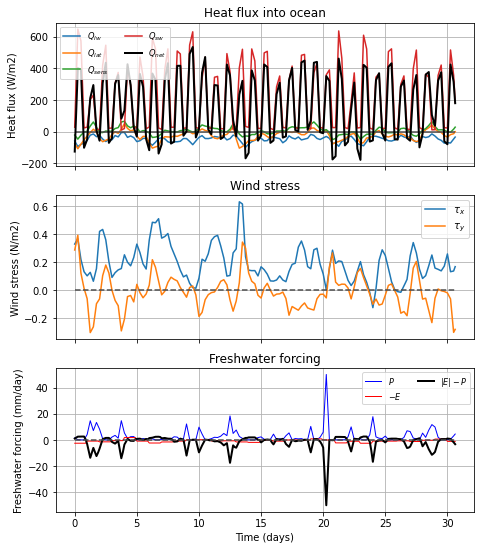

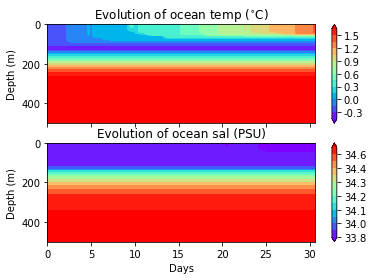

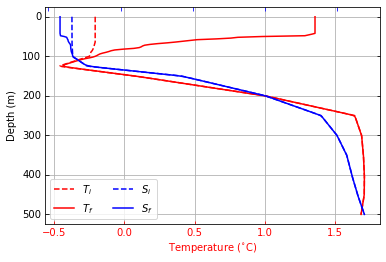

----------------------------------------------------------------------------
NOTE:
See run_demo1() and run_demo2() in PWP_helper.py for more examples.
Additional details can be found here: https://github.com/earlew/pwp_python_00.
----------------------------------------------------------------------------


In [3]:
"""
This is a Python implementation of the Price Weller Pinkel (PWP) ocean mixed layer model. 
This code is based on the MATLAB implementation of the PWP model originally 
written by Peter Lazarevich and Scott Stoermer (http://www.po.gso.uri.edu/rafos/research/pwp/) 
(U. Rhode Island) and later modified by Byron Kilbourne (University of Washington) 
and Sarah Dewey (University of Washington).

The run() function provides an outline of how the code works. 

Earle Wilson
School of Oceanography
University of Washington
April 18, 2016
"""

import numpy as np
import seawater as sw
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import timeit
import os
from datetime import datetime
import PWP_helper as phf
import imp


imp.reload(phf)

#from IPython.core.debugger import Tracer
#debug_here = set_trace

def run(met_data, prof_data, param_kwds=None, overwrite=True, diagnostics=False, suffix='', save_plots=False):
    
    #TODO: move this to the helper file
    """
    This is the main controller function for the model. The flow of the algorithm
    is as follows:
    
        1) Set model parameters (see set_params function in PWP_helper.py). 
        2) Read in forcing and initial profile data.
        3) Prepare forcing and profile data for model run (see prep_data in PWP_helper.py).
            3.1) Interpolate forcing data to prescribed time increments.
            3.2) Interpolate profile data to prescribed depth increments.
            3.3) Initialize model output variables.
        4) Iterate the PWP model specified time interval:
            4.1) apply heat and salt fluxes
            4.2) rotate, adjust to wind, rotate
            4.3) apply bulk Richardson number mixing
            4.4) apply gradient Richardson number mixing
            4.5) apply drag associated with internal wave dissipation
            4.5) apply diapycnal diffusion       
        5) Save results to output file
    
    Input: 
    met_data -  path to netCDF file containing forcing/meterological data. This file must be in the 
                input_data/ directory. 
                
                The data fields should include 'time', 'sw', 'lw', 'qlat', 'qsens', 'tx', 
                'ty', and 'precip'. These fields should store 1-D time series of the same 
                length. 
                
                The model expects positive heat flux values to represent ocean warming. The time
                data field should contain a 1-D array representing fraction of day. For example, 
                for 6 hourly data, met_data['time'] should contain a number series that increases
                in steps of 0.25, such as np.array([1.0, 1.25, 1.75, 2.0, 2.25...]).
    
                See https://github.com/earlew/pwp_python#input-data for more info about the
                expect intput data.
                  
    prof_data - path to netCDF file containing initial profile data. This must be in input_data/ directory.
                The fields of this dataset should include:
                ['z', 't', 's', 'lat']. These represent 1-D vertical profiles of temperature,
                salinity and density. 'lat' is expected to be a length=1 array-like object. e.g. 
                prof_data['lat'] = [25.0].
    
                See https://github.com/earlew/pwp_python#input-data for more info about the
                expect intput data.
    
    overwrite - controls the naming of output file. If True, the same filename is used for 
                every model run. If False, a unique time_stamp is generated and appended
                to the file name. Default is True.
                
    diagnostics - if True, the code will generate live plots of mixed layer properties at 
                each time step.
    
    suffix - string to add to the end of filenames. e.g. suffix = 'nodiff' leads to 'pwp_out_nodiff.nc.
            default is an empty string ''.

    save_plots -this gets passed on to the makeSomePlots() function in the PWP_helper. If True, the code
                saves the generated plots. Default is False.
                
    param_kwds -dict containing keyword arguments for set_params function. See PWP_helper.set_params()
                for more details. If None, default parameters are used. Default is None.
                
    Output:
    
    forcing, pwp_out = PWP.run()
    
    forcing: a dictionary containing the interpolated surface forcing.
    pwp_out: a dictionary containing the solutions generated by the model.
    
    This script also saves the following to file:
    
    'pwp_output.nc'- a netCDF containing the output generated by the model.
    'pwp_output.p' - a pickle file containing the output generated by the model.
    'forcing.p' - a pickle file containing the (interpolated) forcing used for the model run.
    If overwrite is set to False, a timestamp will be added to these file names.
    
    ------------------------------------------------------------------------------
    There are two ways to run the model:
    1.  You can run the model by typing "python PWP.py" from the bash command line. This
        will initiate this function with the set defaults. Typing "%run PWP" from the ipython 
        command line will do the same thing. 
        
    2.  You can also import the module then call the run() function specifically. For example,
        >> import PWP 
        >> forcing, pwp_out = PWP.run()
        Alternatively, if you want to change the defaults...
        >> forcing, pwp_out = PWP.run(met_data='new_forcing.nc', overwrite=False, diagnostics=False)
        
    This is a more interactive approach as it provides direct access to all of the model's
    subfunctions.
        
    """
    
    #close all figures
    plt.close('all')
    
    #start timer
    t0 = timeit.default_timer()
    
    ## Get surface forcing and profile data 
    # These are x-ray datasets, but you can treat them as dicts. 
    # Do met_dset.keys() to explore the data fields
    met_dset = xr.open_dataset('input_data/%s' %met_data) 
    prof_dset = xr.open_dataset('input_data/%s' %prof_data)
    
    ## get model parameters and constants (read docs for set_params function)
    lat = prof_dset['lat'] #needed to compute internal wave dissipation
    if param_kwds is None:
        params = phf.set_params(lat=lat) 
    else:
        param_kwds['lat'] = lat
        params = phf.set_params(**param_kwds)
    
    ## prep forcing and initial profile data for model run (see prep_data function for more details)
    forcing, pwp_out, params = phf.prep_data(met_dset, prof_dset, params)
    
    ## run the model
    pwp_out = pwpgo(forcing, params, pwp_out, diagnostics)
    
         
    ## write output to disk
    if overwrite:
        time_stamp = ''
    else:
        #use unique time stamp
        time_stamp = datetime.now().strftime("_%Y%m%d_%H%M")
    
    if len(suffix)>0 and suffix[0] != '_':
        suffix = '_%s' %suffix
        
    # save output as netCDF file
    pwp_out_ds = xr.Dataset({'temp': (['z', 'time'], pwp_out['temp']), 'sal': (['z', 'time'], pwp_out['sal']), 
                'uvel': (['z', 'time'], pwp_out['uvel']), 'vvel': (['z', 'time'], pwp_out['vvel']),
                'dens': (['z', 'time'],  pwp_out['dens']), 'mld': (['time'],  pwp_out['mld'])}, 
                coords={'z': pwp_out['z'], 'time': pwp_out['time']})

    pwp_out_ds.to_netcdf("output/pwp_output%s%s.nc" %(suffix, time_stamp))

    # also output and forcing as pickle file
    pickle.dump(forcing, open( "output/forcing%s%s.p" %(suffix, time_stamp), "wb" ))
    pickle.dump(pwp_out, open( "output/pwp_out%s%s.p" %(suffix, time_stamp), "wb" ))
    
    #check timer
    tnow = timeit.default_timer()
    t_elapsed  = (tnow - t0)  
    print("Time elapsed: %i minutes and %i seconds" %(np.floor(t_elapsed/60), t_elapsed%60))
    
    ## do analysis of the results
    phf.makeSomePlots(forcing, pwp_out, suffix=suffix, save_plots=save_plots)
    
    return forcing, pwp_out

def pwpgo(forcing, params, pwp_out, diagnostics):

    """
    This is the main driver of the PWP module.
    """
    
    #unpack some of the variables 
    #This is not necessary, but I don't want to update all the variable names just yet.
    q_in = forcing['q_in']
    q_out = forcing['q_out']
    emp = forcing['emp']
    taux = forcing['tx']
    tauy = forcing['ty']
    absrb = forcing['absrb']
    
    z = pwp_out['z']
    dz = pwp_out['dz']
    dt = pwp_out['dt']
    zlen = len(z)
    tlen = len(pwp_out['time'])
    
    rb = params['rb']
    rg = params['rg']
    f = params['f']
    cpw = params['cpw']
    g = params['g']
    ucon = params['ucon']
    
    printDragWarning = True
    
    print("Number of time steps: %s" %tlen)
    
    for n in range(1,tlen):
        percent_comp = 100*n/float(tlen)
        print('Loop iter. %s (%.1f %%)' %(n, percent_comp))
        
        #select for previous profile data
        temp = pwp_out['temp'][:, n-1]
        sal = pwp_out['sal'][:, n-1]
        dens = pwp_out['dens'][:, n-1]
        uvel = pwp_out['uvel'][:, n-1]
        vvel = pwp_out['vvel'][:, n-1]
    
        ### Absorb solar radiation and FWF in surf layer ###
        
        #save initial T,S (may not be necessary)
        temp_old = pwp_out['temp'][0, n-1]
        sal_old = pwp_out['sal'][0, n-1] 
    
        #update layer 1 temp and sal
        temp[0] = temp[0] + (q_in[n-1]*absrb[0]-q_out[n-1])*dt/(dz*dens[0]*cpw)
        #sal[0] = sal[0]/(1-emp[n-1]*dt/dz)
        sal[0] = sal[0] + sal[0]*emp[n-1]*dt/dz
        
        # debug_here()
    
        #check if temp is less than freezing point
        T_fz = sw.fp(sal_old, 1) #why use sal_old? Need to recheck
        if temp[0] < T_fz:
            temp[0] = T_fz
        
        ### Absorb rad. at depth ###
        temp[1:] = temp[1:] + q_in[n-1]*absrb[1:]*dt/(dz*dens[1:]*cpw)
    
        ### compute new density ###
        dens = sw.dens0(sal, temp)
    
        ### relieve static instability ###
        temp, sal, dens, uvel, vvel = remove_si(temp, sal, dens, uvel, vvel)
    
        ### Compute MLD ###       
        #find ml index
        ml_thresh = params['mld_thresh']
        mld_idx = np.flatnonzero(dens-dens[0]>ml_thresh)[0] #finds the first index that exceed ML threshold
    
        #check to ensure that ML is defined
        assert mld_idx.size != 0, "Error: Mixed layer depth is undefined."
    
        #get surf MLD
        mld = z[mld_idx]    
        
        ### Rotate u,v do wind input, rotate again, apply mixing ###
        ang = -f*dt/2
        uvel, vvel = rot(uvel, vvel, ang)
        du = (taux[n-1]/(mld*dens[0]))*dt
        dv = (tauy[n-1]/(mld*dens[0]))*dt
        uvel[:mld_idx] = uvel[:mld_idx]+du
        vvel[:mld_idx] = vvel[:mld_idx]+dv
    

        ### Apply drag to current ###
        #Original comment: this is a horrible parameterization of inertial-internal wave dispersion
        if params['drag_ON']:
            if ucon > 1e-10:
                uvel = uvel*(1-dt*ucon)
                vvel = vvel*(1-dt*ucon)
        else:
            if printDragWarning:
                print("Warning: Parameterization for inertial-internal wave dispersion is turned off.")
                printDragWarning = False

        uvel, vvel = rot(uvel, vvel, ang)
    
        ### Apply Bulk Richardson number instability form of mixing (as in PWP) ###
        if rb > 1e-5:
            temp, sal, dens, uvel, vvel = bulk_mix(temp, sal, dens, uvel, vvel, g, rb, zlen, z, mld_idx)
    
        ### Do the gradient Richardson number instability form of mixing ###
        if rg > 0:
            temp, sal, dens, uvel, vvel = grad_mix(temp, sal, dens, uvel, vvel, dz, g, rg, zlen)
            
        
        ### Apply diffusion ###
        if params['rkz'] > 0:
            temp = diffus(params['dstab'], zlen, temp) 
            sal = diffus(params['dstab'], zlen, sal) 
            dens = sw.dens0(sal, temp)
            uvel = diffus(params['dstab'], zlen, uvel)
            vvel = diffus(params['dstab'], zlen, vvel)
        
        ### update output profile data ###
        pwp_out['temp'][:, n] = temp 
        pwp_out['sal'][:, n] = sal 
        pwp_out['dens'][:, n] = dens
        pwp_out['uvel'][:, n] = uvel
        pwp_out['vvel'][:, n] = vvel
        pwp_out['mld'][n] = mld
    
        #do diagnostics
        if diagnostics==1:
            phf.livePlots(pwp_out, n)
        
    return pwp_out
    

def absorb(beta1, beta2, zlen, dz):
    
    # Compute solar radiation absorption profile. This
    # subroutine assumes two wavelengths, and a double
    # exponential depth dependence for absorption.
    # 
    # Subscript 1 is for red, non-penetrating light, and
    # 2 is for blue, penetrating light. rs1 is the fraction
    # assumed to be red.
    
    rs1 = 0.6
    rs2 = 1.0-rs1
    z1 = np.arange(0,zlen)*dz
    z2 = z1 + dz
    z1b1 = z1/beta1
    z2b1 = z2/beta1
    z1b2 = z1/beta2
    z2b2 = z2/beta2
    absrb = rs1*(np.exp(-z1b1)-np.exp(-z2b1))+rs2*(np.exp(-z1b2)-np.exp(-z2b2))
    
    return absrb
    
def remove_si(t, s, d, u, v):
    
    # Find and relieve static instability that may occur in the
    # density array 'd'. This simulates free convection.
    # ml_index is the index of the depth of the surface mixed layer after adjustment,
    
    stat_unstable = True
      
    while stat_unstable:
        
        d_diff = np.diff(d)
        if np.any(d_diff<0):
            stat_unstable=True
            first_inst_idx = np.flatnonzero(d_diff<0)[0]
            d0 = d
            (t, s, d, u, v) = mix5(t, s, d, u, v, first_inst_idx+1)
            
            #plot density 
            # plt.figure(num=86)
            # plt.clf() #probably redundant
            # plt.plot(d0-1000, range(len(d0)), 'b-', label='pre-mix')
            # plt.plot(d-1000, range(len(d0)), 'r-', label='post-mix')
            # plt.gca().invert_yaxis()
            # plt.xlabel('Density-1000 (kg/m3)')
            # plt.grid(True)
            # plt.pause(0.05)
            # plt.show()
            
            #debug_here()           
        else:
            stat_unstable = False
            
    return t, s, d, u, v
    
    
def mix5(t, s, d, u, v, j):
    
    #This subroutine mixes the arrays t, s, u, v down to level j.
    j = j+1 #so that the j-th layer is included in the mixing
    t[:j] = np.mean(t[:j])
    s[:j] = np.mean(s[:j])
    d[:j] = sw.dens0(s[:j], t[:j])
    u[:j] = np.mean(u[:j])
    v[:j] = np.mean(v[:j])
    
    return t, s, d, u, v
            
def rot(u, v, ang):
    
    #This subroutine rotates the vector (u,v) through an angle, ang
    r = (u+1j*v)*np.exp(1j*ang)
    u = r.real
    v = r.imag
    
    return u, v   
    
def bulk_mix(t, s, d, u, v, g, rb, nz, z, mld_idx):
    #sub-routine to do bulk richardson mixing
    
    rvc = rb #critical rich number??
    
    for j in range(mld_idx, nz):
        h   = z[j]
        #it looks like density and velocity are mixed from the surface down to the ML depth
        dd  = (d[j]-d[0])/d[0]
        dv  = (u[j]-u[0])**2+(v[j]-v[0])**2
        if dv == 0:
            rv = np.inf
        else:
            rv = g*h*dd/dv

        if rv > rvc:
            break
        else:
            t, s, d, u, v = mix5(t, s, d, u, v, j)
            
    return t, s, d, u, v

def grad_mix(t, s, d, u, v, dz, g, rg, nz):
    
    #copied from source script:
    # %  This function performs the gradeint Richardson Number relaxation
    # %  by mixing adjacent cells just enough to bring them to a new
    # %  Richardson Number.      
    # %  Compute the gradeint Richardson Number, taking care to avoid dividing by
    # %  zero in the mixed layer.  The numerical values of the minimum allowable
    # %  density and velocity differences are entirely arbitrary, and should not
    # %  effect the calculations (except that on some occasions they evidently have!)
    #print "entered grad mix"
    
    rc = rg #critical rich. number
    j1 = 0
    j2 = nz-1
    j_range = np.arange(j1,j2)
    i = 0 #loop count
    #debug_here()
    
    while 1:
        #TODO: find a better way to do implement this loop
        
        r = np.zeros(len(j_range))
        
        for j in j_range:
            
            dd = (d[j+1]-d[j])/d[j]
            dv = (u[j+1]-u[j])**2+(v[j+1]-v[j])**2
            if dv==0 or dv<1e-10:
                r[j] = np.inf
            else:
                #compute grad. rich. number
                r[j] = g*dz*dd/dv                
         
        #debug_here()       
        #find the smallest value of r in the profile
        r_min = np.min(r)
        j_min_idx = np.argmin(r)
        
        #Check to see whether the smallest r is critical or not.
        if r_min > rc:
            break
            
        #Mix the cells j_min_idx and j_min_idx+1 that had the smallest Richardson Number
        t, s, d, u, v = stir(t, s, d, u, v, rc, r_min, j_min_idx)
        
        #recompute the rich number over the part of the profile that has changed
        j1 = j_min_idx-2
        if j1 < 1:
             j1 = 0
        
        j2 = j_min_idx+2
        if j2 > nz-1:
             j2 = nz-1
             
        i+=1
                     
    return t, s, d, u, v
                
def stir(t, s, d, u, v, rc, r, j):
    
    #copied from source script:
    
    # %  This subroutine mixes cells j and j+1 just enough so that
    # %  the Richardson number after the mixing is brought up to
    # %  the value rnew. In order to have this mixing process
    # %  converge, rnew must exceed the critical value of the
    # %  richardson number where mixing is presumed to start. If
    # %  r critical = rc = 0.25 (the nominal value), and r = 0.20, then
    # %  rnew = 0.3 would be reasonable. If r were smaller, then a
    # %  larger value of rnew - rc is used to hasten convergence.
    #
    # %  This subroutine was modified by JFP in Sep 93 to allow for an
    # %  aribtrary rc and to achieve faster convergence.
    
    #TODO: This needs better commenting
    rcon = 0.02+(rc-r)/2
    rnew = rc+rcon/5.
    f = 1-r/rnew
    
    #mix temp
    dt = (t[j+1]-t[j])*f/2.
    t[j+1] = t[j+1]-dt
    t[j] = t[j]+dt
    
    #mix sal
    ds = (s[j+1]-s[j])*f/2.
    s[j+1] = s[j+1]-ds
    s[j] = s[j]+ds
    
    #recompute density 
    #d[j:j+1] = sw.dens0(s[j:j+1], t[j:j+1]) 
    #have to be careful here. x[j:j+1] in python is not the same as x[[j,j+1]]. We want the latter
    d[[j,j+1]] = sw.dens0(s[[j,j+1]], t[[j,j+1]])
    
    du = (u[j+1]-u[j])*f/2
    u[j+1] = u[j+1]-du
    u[j] = u[j]+du
    
    dv = (v[j+1]-v[j])*f/2
    v[j+1] = v[j+1]-dv
    v[j] = v[j]+dv
    
    return t, s, d, u, v
    
def diffus(dstab,nz,a):
    
    "finite difference implementation of diffusion equation"
     
    #matlab code:
    #a(2:nz-1) = a(2:nz-1) + dstab*(a(1:nz-2) - 2*a(2:nz-1) + a(3:nz));
    
    a[1:nz-1] = a[1:nz-1] + dstab*(a[0:nz-2] - 2*a[1:nz-1] + a[2:nz]) 
    return a    

if __name__ == "__main__":
    
    print("Running default test case using data from Beaufort gyre...")
    
    forcing_fname ='SO_met_30day.nc' #'beaufort_met.nc'
    prof_fname = 'SO_profile1.nc'#'beaufort_profile.nc'
    p={}
    p['rkz']=1e-6
    p['dz'] = 2.0
    p['max_depth'] = 500.0
    forcing, pwp_out = run(met_data=forcing_fname, prof_data=prof_fname, save_plots=True, param_kwds=p)
    print("----------------------------------------------------------------------------")
    print("NOTE:\nSee run_demo1() and run_demo2() in PWP_helper.py for more examples.")
    print("Additional details can be found here: https://github.com/earlew/pwp_python_00.")
    print("----------------------------------------------------------------------------")


In [6]:
import netCDF4

f = netCDF4.Dataset(r"C:\Users\Asus\Simulation\pwp_python_00-master\output\pwp_output.nc")
f.variables.keys()

dict_keys(['temp', 'sal', 'uvel', 'vvel', 'dens', 'mld', 'z', 'time'])